In [1]:
import os
import glob
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image
import zipfile
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")
meta_data = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/metadata.csv")

df = pd.merge(df_label, meta_data, left_on='SeriesInstanceUID', right_on='Series UID', how='left')
list_StudyInstanceUID = list(df[df['Modality'] == 'SEG']['StudyInstanceUID'])
filtered_df = df[df['StudyInstanceUID'].isin(list_StudyInstanceUID)]

/tmp/ipykernel_36/4002129541.py:1: DtypeWarning: Columns (5,9,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")


In [3]:
# Count the occurrences of each 'Patient ID' based on 'Modality'
modality_counts = filtered_df['Patient ID'].value_counts()

# Identify the 'Patient ID' with the smallest count
min_patient_id = modality_counts.idxmin()
min_count = modality_counts.min()

# Output the result
print(f"Patient ID with the smallest number of modalities: {min_patient_id}, Count: {min_count}")

Patient ID with the smallest number of modalities: R01-058, Count: 113


In [54]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image

class DICOMPreprocessing:
    def __init__(self, patient_df):
        self.patient_df = patient_df
        self.ct_df = patient_df[patient_df['Modality'] == 'CT']
        self.seg_df = patient_df[patient_df['Modality'] == 'SEG']

        # Create dictionaries to map SOP Instance UID to their file paths
        self.ct_dict = dict(zip(self.ct_df['SOPInstanceUID'], self.ct_df['image_path']))
        self.seg_dict = dict(zip(self.seg_df['SOPInstanceUID'], self.seg_df['image_path']))

    @staticmethod
    def load_and_prepare_data():
        """Load and prepare data from CSV files."""
        df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")
        meta_data = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/metadata.csv")

        df = pd.merge(df_label, meta_data, left_on='SeriesInstanceUID', right_on='Series UID', how='left')
        list_StudyInstanceUID = list(df[df['Modality'] == 'SEG']['StudyInstanceUID'])
        filtered_df = df[df['StudyInstanceUID'].isin(list_StudyInstanceUID)]

        patient_dict = {patient_id: filtered_df[filtered_df['Patient ID'] == patient_id] for patient_id in df['Patient ID'].unique()}
        key_list = list(set(filtered_df['Patient ID']))

        patient_variables = {f'patient_{n}': patient_dict[key] for n, key in enumerate(key_list)}
        list_key = list(set(patient_variables.keys()))

        return patient_variables, list_key

    def _get_tumor_bounding_box(self, seg_slice):
        """Compute the bounding box for the segmented tumor area."""
        tumor_pixels = np.argwhere(seg_slice > 0)
        if tumor_pixels.size == 0:
            return (0, 0, seg_slice.shape[1], seg_slice.shape[0])

        min_y, min_x = tumor_pixels.min(axis=0)
        max_y, max_x = tumor_pixels.max(axis=0)

        return (min_x, min_y, max_x + 1, max_y + 1)

    def _find_largest_masks(self, num_masks=2):
        """Find the largest mask areas in the segmentations and their order."""
        masks = []

        for _, seg_row in self.seg_df.iterrows():
            seg_uid = seg_row['SOPInstanceUID']
            seg_image_path = self.seg_dict.get(seg_uid)
            if not seg_image_path:
                continue

            try:
                seg_ds = pydicom.dcmread(seg_image_path)
            except Exception as e:
                print(f"Error reading SEG image {seg_uid}: {e}")
                continue

            referenced_series_sequence = seg_ds.get('ReferencedSeriesSequence', [])
            for series_item in referenced_series_sequence:
                referenced_instance_sequence = series_item.get('ReferencedInstanceSequence', [])
                for idx, instance_item in enumerate(referenced_instance_sequence):
                    ct_sop_instance_uid = instance_item.get('ReferencedSOPInstanceUID', 'N/A')
                    ct_image_path = self.ct_dict.get(ct_sop_instance_uid)
                    if not ct_image_path:
                        continue

                    try:
                        ct_ds = pydicom.dcmread(ct_image_path)
                        ct_pixel_array = ct_ds.pixel_array
                        seg_slice = seg_ds.pixel_array[idx, :, :]
                    except Exception as e:
                        print(f"Error reading CT image {ct_sop_instance_uid}: {e}")
                        continue

                    if seg_slice.size == 0 or ct_pixel_array.size == 0:
                        continue

                    mask_area = np.sum(seg_slice > 0)
                    masks.append((mask_area, seg_uid, ct_pixel_array, seg_slice, idx))  # Include index

        masks.sort(reverse=True, key=lambda x: x[0])
        return masks[:num_masks]
    
    def save_largest_tumor_areas(self, output_dir, image_size=(224, 224), num_masks=5): 
        """Find the largest tumor areas, resize them, and save them as TIFF images."""
        os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
        largest_masks = self._find_largest_masks(num_masks=num_masks)

        total_masks = len(largest_masks)
        if total_masks == 0:
            print("No masks available to save.")
            return

        largest_idx = 0  # The largest mask is at index 0

        # Prepare indices to save
        indices_to_save = []
        if total_masks >= num_masks:
            # Collect indices for saving: two before, one largest, and two after
            indices_to_save = [
                max(largest_idx - 2, 0),
                max(largest_idx - 1, 0),
                largest_idx,
                min(largest_idx + 1, total_masks - 1),
                min(largest_idx + 2, total_masks - 1)
            ]
        else:
            # If fewer masks, save all available
            indices_to_save = list(range(total_masks))

        # Save the extracted regions
        for i, idx in enumerate(indices_to_save[:num_masks]):  # Only save up to num_masks
            mask_area, mask_uid, ct_pixel_array, seg_slice, _ = largest_masks[idx]

            # Extract the tumor area
            tumor_bbox = self._get_tumor_bounding_box(seg_slice)
            min_x, min_y, max_x, max_y = tumor_bbox

            # Zoom into the tumor area
            extracted_region = ct_pixel_array[min_y:max_y, min_x:max_x]

            # Normalize to 0-255 range for saving as TIFF
            extracted_region_normalized = 255 * (extracted_region - np.min(extracted_region)) / (np.max(extracted_region) - np.min(extracted_region))
            extracted_region_normalized = np.uint8(extracted_region_normalized)

            # Create a PIL Image object
            image = Image.fromarray(extracted_region_normalized)

            # Resize the image
            image = image.resize(image_size, Image.BICUBIC)

            # Save the image as TIFF with a unique name including the index
            file_name = f"{mask_uid}_{i + 1}.tiff"  # Unique naming
            file_path = os.path.join(output_dir, file_name)
            image.save(file_path, format='TIFF')
            print(f"Saved tumor area image to {file_path}")

    
    def visualize_largest_masks_with_adjacent(self):
        """Visualize the largest mask and its adjacent slices along with the extracted regions."""
        largest_masks = self._find_largest_masks()
        if not largest_masks:
            print("No largest masks found.")
            return

        total_masks = len(largest_masks)
        largest_idx = 0  # The largest mask is at index 0

        # Prepare indices to visualize
        indices_to_visualize = [
            max(largest_idx - 2, 0), 
            max(largest_idx - 1, 0), 
            largest_idx, 
            min(largest_idx + 1, total_masks - 1), 
            min(largest_idx + 2, total_masks - 1)
        ]

        # Create a figure to visualize
        plt.figure(figsize=(20, 15))
        plt.suptitle("Visualizing Largest Mask and Adjacent Masks", fontsize=18, y=0.95)

        for i, idx in enumerate(indices_to_visualize):
            mask_area, mask_uid, ct_pixel_array, seg_slice, _ = largest_masks[idx]

            # Plot CT Slice
            plt.subplot(2, 5, i + 1)
            plt.imshow(ct_pixel_array, cmap='gray')
            highlighted_seg = np.zeros_like(seg_slice)
            highlighted_seg[seg_slice > 0] = 1
            contours = measure.find_contours(highlighted_seg, level=0.5)
            for contour in contours:
                plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)

            # Set title: only show UID for the largest mask
            if i == 2:  # Middle slice (largest)
                plt.title(f"UID: {mask_uid}\nArea: {mask_area}", fontsize=12)
            else:  # Adjacent slices
                plt.title("Adjacent Slice", fontsize=12)

            plt.axis('off')

            # Extracted Region
            tumor_bbox = self._get_tumor_bounding_box(seg_slice)
            min_x, min_y, max_x, max_y = tumor_bbox
            extracted_region = ct_pixel_array[min_y:max_y, min_x:max_x]

            # Plot Extracted Region
            plt.subplot(2, 5, i + 6)
            plt.imshow(extracted_region, cmap='gray')
            plt.title("Extracted Region", fontsize=12)
            plt.axis('off')

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout for titles
        plt.show()  # Display the figure

    def visualize_all(self):
        """Visualize the largest masks for all patients."""
        for patient_key in self.patient_df['Patient ID'].unique():
            patient_data = self.patient_df[self.patient_df['Patient ID'] == patient_key]
            dicom_preprocessor = DICOMPreprocessing(patient_df=patient_data)

            print(f"Visualizing patient {patient_key}")
            dicom_preprocessor.visualize_largest_masks_with_adjacent()

    def save_all(self, output_dir, image_size=(224, 224)):
        """Save the largest tumor areas for all patients."""
        for patient_key in self.patient_df['Patient ID'].unique():
            patient_data = self.patient_df[self.patient_df['Patient ID'] == patient_key]
            dicom_preprocessor = DICOMPreprocessing(patient_df=patient_data)

            print(f"Saving images for patient {patient_key}")
            dicom_preprocessor.save_largest_tumor_areas(output_dir, image_size=image_size)

/tmp/ipykernel_36/630721515.py:22: DtypeWarning: Columns (5,9,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")


Visualizing patient patient_44


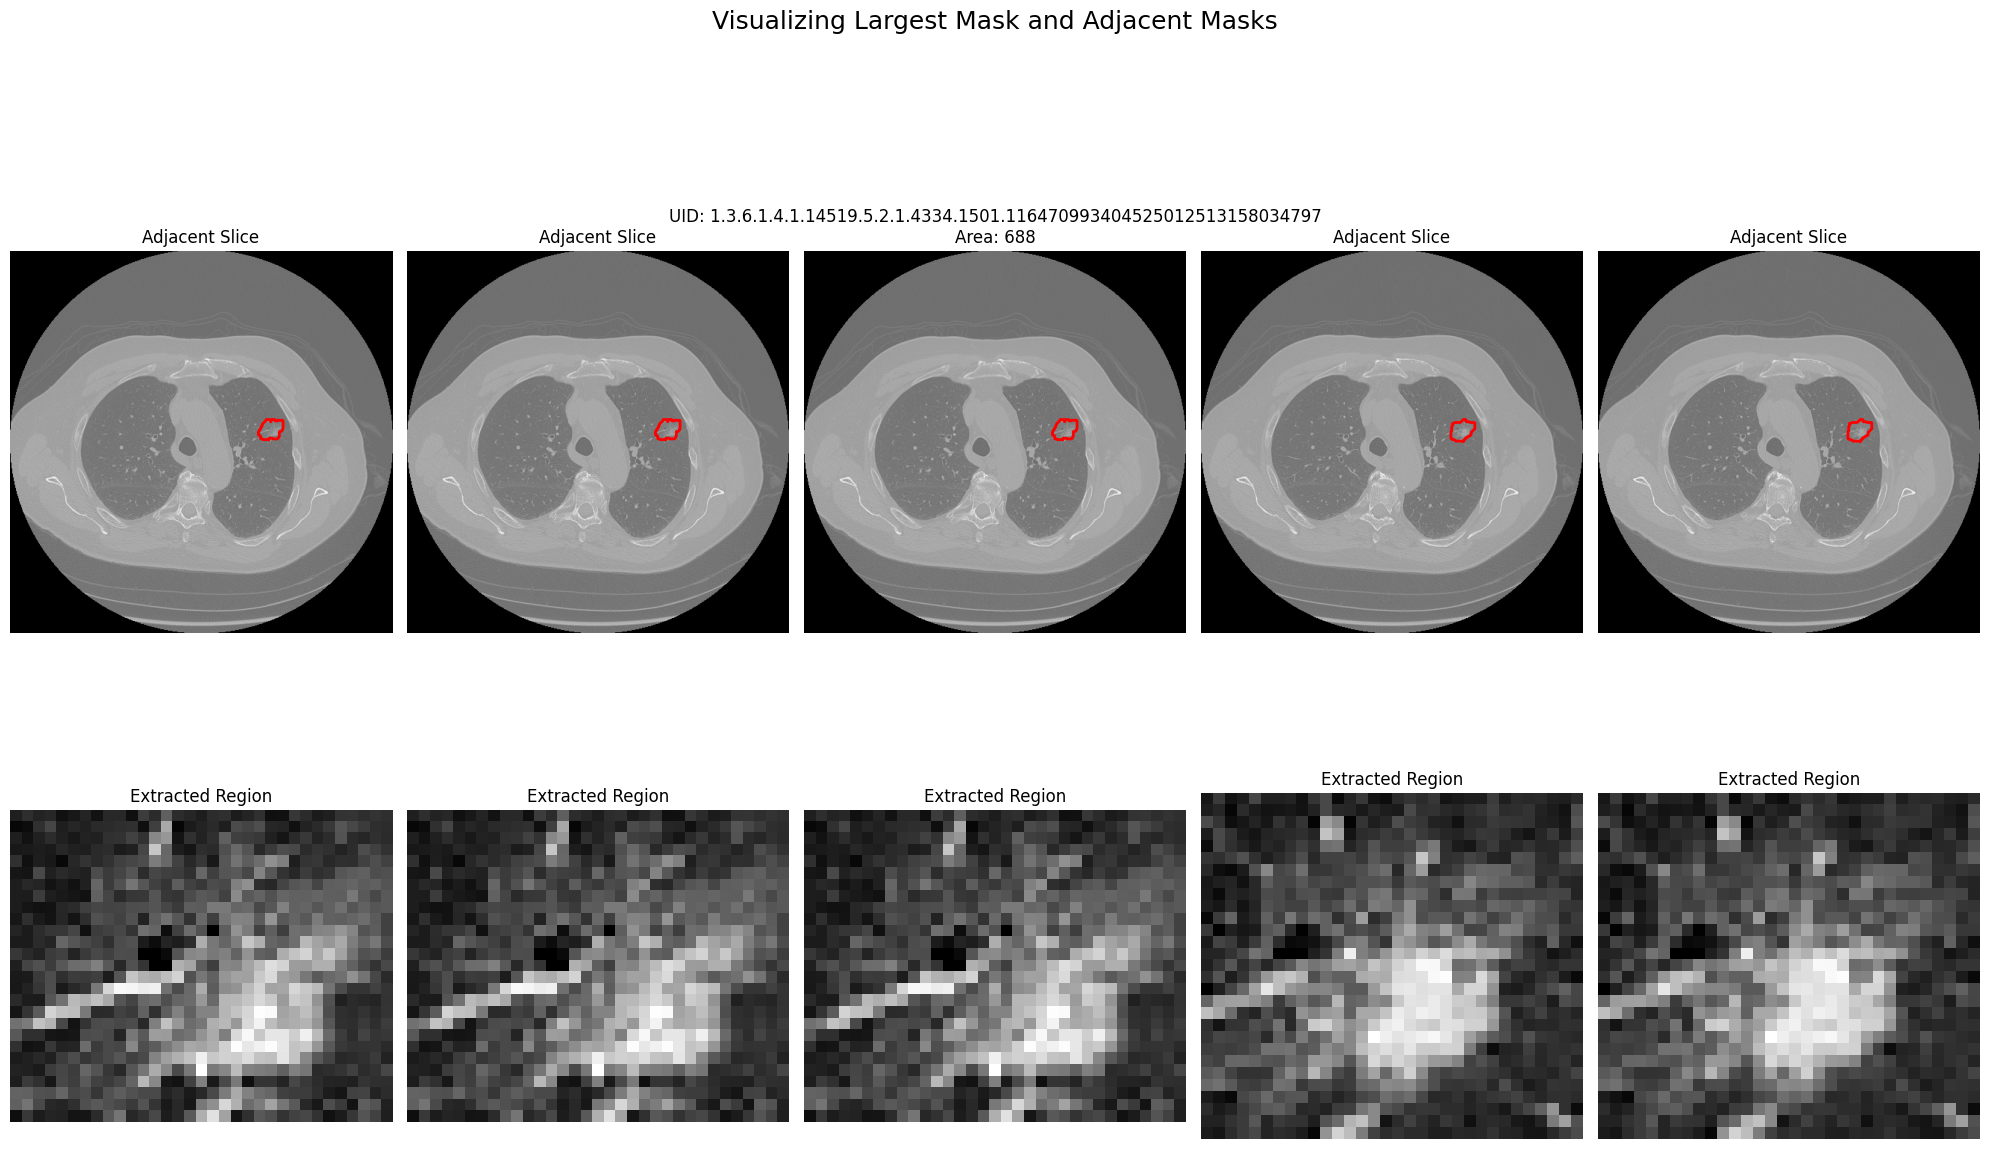

In [55]:
import time

# Load and prepare data
patient_variables, list_key = DICOMPreprocessing.load_and_prepare_data()

# Visualization for patients
for patient_key in list_key[2:3]:  # Adjust the slice for more patients if needed
    try:
        dicom_preprocessor = DICOMPreprocessing(patient_df=patient_variables[patient_key])
        print(f"Visualizing patient {patient_key}")
        dicom_preprocessor.visualize_largest_masks_with_adjacent()
    except Exception as e:
        print(f"Error visualizing patient {patient_key}: {e}")
    
    time.sleep(5)  # Rest for 5 seconds between patients to avoid overloading

In [56]:
import shutil
import os

# Define the directory to clear
working_dir = '/kaggle/working/output_images'
os.makedirs(working_dir,exist_ok=True)
# Check if the directory exists
if os.path.exists(working_dir):
    # Remove all contents in the directory
    shutil.rmtree(working_dir)
    # Recreate the directory
    os.makedirs(working_dir)
    print(f"Cleared and recreated the directory: {working_dir}")
else:
    print(f"Directory {working_dir} does not exist.")

Cleared and recreated the directory: /kaggle/working/output_images


In [57]:
from tqdm import tqdm
import gc

# Iterate through each patient and save tumor areas with progress tracking
for patient_key in tqdm(list_key, desc="Saving tumor areas"):
    # Initialize the DICOMPreprocessing class for the current patient
    dicom_preprocessor = DICOMPreprocessing(patient_df=patient_variables[patient_key])

    # Save the largest tumor areas for the current patient
    dicom_preprocessor.save_largest_tumor_areas(output_dir=working_dir, image_size=(224, 224))

    # Release memory for the current patient
    del dicom_preprocessor
    gc.collect()

Saving tumor areas:   1%|          | 1/144 [00:02<05:24,  2.27s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210583834547833020270614633968_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210583834547833020270614633968_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210583834547833020270614633968_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210583834547833020270614633968_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210583834547833020270614633968_5.tiff


Saving tumor areas:   1%|▏         | 2/144 [00:03<04:03,  1.72s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296312982213702857488999502080_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296312982213702857488999502080_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296312982213702857488999502080_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296312982213702857488999502080_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296312982213702857488999502080_5.tiff


Saving tumor areas:   2%|▏         | 3/144 [00:04<03:15,  1.39s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.116470993404525012513158034797_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.116470993404525012513158034797_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.116470993404525012513158034797_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.116470993404525012513158034797_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.116470993404525012513158034797_5.tiff


Saving tumor areas:   3%|▎         | 4/144 [00:07<04:14,  1.82s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.239434800461566851862479789896_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.239434800461566851862479789896_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.239434800461566851862479789896_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.239434800461566851862479789896_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.239434800461566851862479789896_5.tiff


Saving tumor areas:   3%|▎         | 5/144 [00:09<04:42,  2.03s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254560949327495733867144438706_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254560949327495733867144438706_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254560949327495733867144438706_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254560949327495733867144438706_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254560949327495733867144438706_5.tiff


Saving tumor areas:   4%|▍         | 6/144 [00:10<03:39,  1.59s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.335797460926179994099221406115_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.335797460926179994099221406115_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.335797460926179994099221406115_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.335797460926179994099221406115_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.335797460926179994099221406115_5.tiff


Saving tumor areas:   5%|▍         | 7/144 [00:10<02:54,  1.27s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275453297667129803503963496373_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275453297667129803503963496373_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275453297667129803503963496373_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275453297667129803503963496373_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275453297667129803503963496373_5.tiff


Saving tumor areas:   6%|▌         | 8/144 [00:11<02:36,  1.15s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275624415262168281710581152122_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275624415262168281710581152122_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275624415262168281710581152122_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275624415262168281710581152122_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275624415262168281710581152122_5.tiff


Saving tumor areas:   6%|▋         | 9/144 [00:12<02:04,  1.09it/s]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.997878677073619595638594480652_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.997878677073619595638594480652_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.997878677073619595638594480652_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.997878677073619595638594480652_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.997878677073619595638594480652_5.tiff


Saving tumor areas:   7%|▋         | 10/144 [00:16<04:16,  1.91s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.114261476622627046716051771833_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.114261476622627046716051771833_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.114261476622627046716051771833_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.114261476622627046716051771833_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.114261476622627046716051771833_5.tiff


Saving tumor areas:   8%|▊         | 11/144 [00:20<05:33,  2.51s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243854333542661068553_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243854333542661068553_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243854333542661068553_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243854333542661068553_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243854333542661068553_5.tiff


Saving tumor areas:   8%|▊         | 12/144 [00:24<06:39,  3.02s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.199785130945170463543472115965_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.199785130945170463543472115965_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.199785130945170463543472115965_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.199785130945170463543472115965_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.199785130945170463543472115965_5.tiff


Saving tumor areas:   9%|▉         | 13/144 [00:26<06:10,  2.83s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144425081742517191847604606512_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144425081742517191847604606512_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144425081742517191847604606512_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144425081742517191847604606512_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144425081742517191847604606512_5.tiff


Saving tumor areas:  10%|▉         | 14/144 [00:32<08:12,  3.79s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.965353665272099976571829330165_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.965353665272099976571829330165_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.965353665272099976571829330165_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.965353665272099976571829330165_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.965353665272099976571829330165_5.tiff


Saving tumor areas:  10%|█         | 15/144 [00:43<12:45,  5.94s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261249713773269853972467618279_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261249713773269853972467618279_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261249713773269853972467618279_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261249713773269853972467618279_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261249713773269853972467618279_5.tiff


Saving tumor areas:  11%|█         | 16/144 [00:48<12:06,  5.67s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.235963655862954404967259088811_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.235963655862954404967259088811_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.235963655862954404967259088811_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.235963655862954404967259088811_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.235963655862954404967259088811_5.tiff


Saving tumor areas:  12%|█▏        | 17/144 [00:59<15:05,  7.13s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118381592990846613081890048750_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118381592990846613081890048750_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118381592990846613081890048750_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118381592990846613081890048750_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118381592990846613081890048750_5.tiff


Saving tumor areas:  12%|█▎        | 18/144 [01:03<13:01,  6.20s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203778397654420341159508431102_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203778397654420341159508431102_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203778397654420341159508431102_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203778397654420341159508431102_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203778397654420341159508431102_5.tiff


Saving tumor areas:  13%|█▎        | 19/144 [01:07<11:53,  5.71s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.305990201524202424433054613200_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.305990201524202424433054613200_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.305990201524202424433054613200_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.305990201524202424433054613200_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.305990201524202424433054613200_5.tiff


Saving tumor areas:  14%|█▍        | 20/144 [01:13<11:29,  5.56s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311533574623007377892868038852_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311533574623007377892868038852_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311533574623007377892868038852_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311533574623007377892868038852_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311533574623007377892868038852_5.tiff


Saving tumor areas:  15%|█▍        | 21/144 [01:13<08:18,  4.06s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.310879094108601450393769158799_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.310879094108601450393769158799_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.310879094108601450393769158799_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.310879094108601450393769158799_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.310879094108601450393769158799_5.tiff


Saving tumor areas:  15%|█▌        | 22/144 [01:15<07:04,  3.48s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307181903788310291391890331288_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307181903788310291391890331288_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307181903788310291391890331288_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307181903788310291391890331288_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307181903788310291391890331288_5.tiff


Saving tumor areas:  16%|█▌        | 23/144 [01:16<05:15,  2.61s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.151961065370148535046833652338_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.151961065370148535046833652338_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.151961065370148535046833652338_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.151961065370148535046833652338_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.151961065370148535046833652338_5.tiff


Saving tumor areas:  17%|█▋        | 24/144 [01:20<06:16,  3.14s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118835658322930280083721786560_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118835658322930280083721786560_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118835658322930280083721786560_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118835658322930280083721786560_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118835658322930280083721786560_5.tiff


Saving tumor areas:  17%|█▋        | 25/144 [01:25<07:31,  3.79s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481755705659472973690_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481755705659472973690_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481755705659472973690_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481755705659472973690_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481755705659472973690_5.tiff


Saving tumor areas:  18%|█▊        | 26/144 [01:27<06:01,  3.07s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_5.tiff


Saving tumor areas:  19%|█▉        | 27/144 [01:31<06:49,  3.50s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.559078504766516849307983964467_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.559078504766516849307983964467_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.559078504766516849307983964467_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.559078504766516849307983964467_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.559078504766516849307983964467_5.tiff


Saving tumor areas:  19%|█▉        | 28/144 [01:32<05:03,  2.62s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194234966914983778489661901338_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194234966914983778489661901338_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194234966914983778489661901338_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194234966914983778489661901338_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194234966914983778489661901338_5.tiff


Saving tumor areas:  20%|██        | 29/144 [01:34<04:49,  2.52s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307656421227591022298133385915_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307656421227591022298133385915_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307656421227591022298133385915_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307656421227591022298133385915_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307656421227591022298133385915_5.tiff


Saving tumor areas:  21%|██        | 30/144 [01:39<06:16,  3.30s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879_5.tiff


Saving tumor areas:  22%|██▏       | 31/144 [01:42<05:44,  3.05s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.130428586467280386032069092384_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.130428586467280386032069092384_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.130428586467280386032069092384_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.130428586467280386032069092384_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.130428586467280386032069092384_5.tiff


Saving tumor areas:  22%|██▏       | 32/144 [01:43<04:49,  2.59s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.271205290243896201307722464013_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.271205290243896201307722464013_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.271205290243896201307722464013_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.271205290243896201307722464013_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.271205290243896201307722464013_5.tiff


Saving tumor areas:  23%|██▎       | 33/144 [01:44<03:57,  2.14s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.246834405982941702724047970820_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.246834405982941702724047970820_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.246834405982941702724047970820_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.246834405982941702724047970820_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.246834405982941702724047970820_5.tiff


Saving tumor areas:  24%|██▎       | 34/144 [01:49<05:30,  3.01s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.312463295148507978259306983627_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.312463295148507978259306983627_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.312463295148507978259306983627_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.312463295148507978259306983627_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.312463295148507978259306983627_5.tiff


Saving tumor areas:  24%|██▍       | 35/144 [01:54<06:28,  3.56s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_5.tiff


Saving tumor areas:  25%|██▌       | 36/144 [01:55<04:55,  2.73s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.685339142284878388826567597209_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.685339142284878388826567597209_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.685339142284878388826567597209_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.685339142284878388826567597209_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.685339142284878388826567597209_5.tiff


Saving tumor areas:  26%|██▌       | 37/144 [02:00<06:00,  3.37s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.326304819110913391852711914100_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.326304819110913391852711914100_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.326304819110913391852711914100_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.326304819110913391852711914100_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.326304819110913391852711914100_5.tiff


Saving tumor areas:  26%|██▋       | 38/144 [02:04<06:30,  3.69s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296024917315107128651362696187_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296024917315107128651362696187_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296024917315107128651362696187_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296024917315107128651362696187_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296024917315107128651362696187_5.tiff


Saving tumor areas:  27%|██▋       | 39/144 [02:05<04:45,  2.72s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272716599566473061076639049737_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272716599566473061076639049737_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272716599566473061076639049737_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272716599566473061076639049737_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272716599566473061076639049737_5.tiff


Saving tumor areas:  28%|██▊       | 40/144 [02:10<05:59,  3.46s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.324156147013626649778342052367_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.324156147013626649778342052367_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.324156147013626649778342052367_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.324156147013626649778342052367_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.324156147013626649778342052367_5.tiff


Saving tumor areas:  28%|██▊       | 41/144 [02:14<06:09,  3.59s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.103761676701359868785654810879_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.103761676701359868785654810879_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.103761676701359868785654810879_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.103761676701359868785654810879_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.103761676701359868785654810879_5.tiff


Saving tumor areas:  29%|██▉       | 42/144 [02:19<06:41,  3.94s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.163909679551662375421207740492_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.163909679551662375421207740492_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.163909679551662375421207740492_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.163909679551662375421207740492_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.163909679551662375421207740492_5.tiff


Saving tumor areas:  30%|██▉       | 43/144 [02:21<05:52,  3.49s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.696149824662228954005362078362_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.696149824662228954005362078362_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.696149824662228954005362078362_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.696149824662228954005362078362_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.696149824662228954005362078362_5.tiff


Saving tumor areas:  31%|███       | 44/144 [02:22<04:25,  2.65s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309755826175620154393954985992_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309755826175620154393954985992_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309755826175620154393954985992_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309755826175620154393954985992_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309755826175620154393954985992_5.tiff


Saving tumor areas:  31%|███▏      | 45/144 [02:26<05:01,  3.04s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.248406254903351301069927596067_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.248406254903351301069927596067_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.248406254903351301069927596067_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.248406254903351301069927596067_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.248406254903351301069927596067_5.tiff


Saving tumor areas:  32%|███▏      | 46/144 [02:28<04:42,  2.88s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315079754680130788149_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315079754680130788149_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315079754680130788149_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315079754680130788149_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315079754680130788149_5.tiff


Saving tumor areas:  33%|███▎      | 47/144 [02:31<04:20,  2.69s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387_5.tiff


Saving tumor areas:  33%|███▎      | 48/144 [02:32<03:31,  2.20s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153424202782775072915123179605_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153424202782775072915123179605_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153424202782775072915123179605_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153424202782775072915123179605_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153424202782775072915123179605_5.tiff


Saving tumor areas:  34%|███▍      | 49/144 [02:32<02:45,  1.74s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.995379276753775844765349592955_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.995379276753775844765349592955_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.995379276753775844765349592955_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.995379276753775844765349592955_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.995379276753775844765349592955_5.tiff


Saving tumor areas:  35%|███▍      | 50/144 [02:37<04:09,  2.65s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.161222917130136044103450487390_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.161222917130136044103450487390_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.161222917130136044103450487390_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.161222917130136044103450487390_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.161222917130136044103450487390_5.tiff


Saving tumor areas:  35%|███▌      | 51/144 [02:43<05:34,  3.60s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308513455887574850277205266793_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308513455887574850277205266793_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308513455887574850277205266793_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308513455887574850277205266793_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308513455887574850277205266793_5.tiff


Saving tumor areas:  36%|███▌      | 52/144 [02:50<06:58,  4.55s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.207443943407455870340595435813_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.207443943407455870340595435813_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.207443943407455870340595435813_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.207443943407455870340595435813_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.207443943407455870340595435813_5.tiff


Saving tumor areas:  37%|███▋      | 53/144 [02:50<05:00,  3.30s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107717629673846674203854064634_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107717629673846674203854064634_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107717629673846674203854064634_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107717629673846674203854064634_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107717629673846674203854064634_5.tiff


Saving tumor areas:  38%|███▊      | 54/144 [02:54<05:25,  3.62s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203635672592149412227415389883_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203635672592149412227415389883_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203635672592149412227415389883_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203635672592149412227415389883_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203635672592149412227415389883_5.tiff


Saving tumor areas:  38%|███▊      | 55/144 [02:59<05:44,  3.87s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.204029995422721230836785661596_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.204029995422721230836785661596_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.204029995422721230836785661596_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.204029995422721230836785661596_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.204029995422721230836785661596_5.tiff


Saving tumor areas:  39%|███▉      | 56/144 [02:59<04:12,  2.87s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115868185078472232968938556560_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115868185078472232968938556560_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115868185078472232968938556560_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115868185078472232968938556560_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115868185078472232968938556560_5.tiff


Saving tumor areas:  40%|███▉      | 57/144 [03:00<03:15,  2.24s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.895257848716513258319505812731_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.895257848716513258319505812731_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.895257848716513258319505812731_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.895257848716513258319505812731_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.895257848716513258319505812731_5.tiff


Saving tumor areas:  40%|████      | 58/144 [03:07<05:03,  3.53s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296302715635385591412290568238_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296302715635385591412290568238_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296302715635385591412290568238_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296302715635385591412290568238_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296302715635385591412290568238_5.tiff


Saving tumor areas:  41%|████      | 59/144 [03:12<05:43,  4.04s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194849568492835137645001869117_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194849568492835137645001869117_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194849568492835137645001869117_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194849568492835137645001869117_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194849568492835137645001869117_5.tiff


Saving tumor areas:  42%|████▏     | 60/144 [03:13<04:24,  3.15s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.171030500113786957723142909947_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.171030500113786957723142909947_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.171030500113786957723142909947_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.171030500113786957723142909947_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.171030500113786957723142909947_5.tiff


Saving tumor areas:  42%|████▏     | 61/144 [03:18<04:56,  3.58s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115590393198684542336235262453_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115590393198684542336235262453_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115590393198684542336235262453_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115590393198684542336235262453_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115590393198684542336235262453_5.tiff


Saving tumor areas:  43%|████▎     | 62/144 [03:18<03:37,  2.66s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.861261956852330424243534438431_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.861261956852330424243534438431_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.861261956852330424243534438431_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.861261956852330424243534438431_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.861261956852330424243534438431_5.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261114095052379120210021776760_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261114095052379120210021776760_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.26111409505237

Saving tumor areas:  44%|████▍     | 64/144 [03:23<03:06,  2.33s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.256513934865025219917434671237_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.256513934865025219917434671237_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.256513934865025219917434671237_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.256513934865025219917434671237_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.256513934865025219917434671237_5.tiff


Saving tumor areas:  45%|████▌     | 65/144 [03:23<02:24,  1.82s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.247287504247665232817081802268_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.247287504247665232817081802268_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.247287504247665232817081802268_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.247287504247665232817081802268_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.247287504247665232817081802268_5.tiff


Saving tumor areas:  46%|████▌     | 66/144 [03:28<03:31,  2.71s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.165554541812737547045545126699_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.165554541812737547045545126699_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.165554541812737547045545126699_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.165554541812737547045545126699_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.165554541812737547045545126699_5.tiff


Saving tumor areas:  47%|████▋     | 67/144 [03:29<02:41,  2.10s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.286601297126453465879824328207_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.286601297126453465879824328207_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.286601297126453465879824328207_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.286601297126453465879824328207_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.286601297126453465879824328207_5.tiff


Saving tumor areas:  47%|████▋     | 68/144 [03:30<02:06,  1.66s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227828658416444165019136725393_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227828658416444165019136725393_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227828658416444165019136725393_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227828658416444165019136725393_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227828658416444165019136725393_5.tiff


Saving tumor areas:  48%|████▊     | 69/144 [03:30<01:41,  1.35s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183345524286206632983235013499_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183345524286206632983235013499_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183345524286206632983235013499_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183345524286206632983235013499_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183345524286206632983235013499_5.tiff


Saving tumor areas:  49%|████▊     | 70/144 [03:35<03:02,  2.46s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.334955403098633167411200408058_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.334955403098633167411200408058_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.334955403098633167411200408058_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.334955403098633167411200408058_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.334955403098633167411200408058_5.tiff


Saving tumor areas:  49%|████▉     | 71/144 [03:36<02:29,  2.04s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.365334038172941249215997103092_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.365334038172941249215997103092_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.365334038172941249215997103092_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.365334038172941249215997103092_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.365334038172941249215997103092_5.tiff


Saving tumor areas:  50%|█████     | 72/144 [03:41<03:33,  2.96s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.120580281843836954931899934243_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.120580281843836954931899934243_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.120580281843836954931899934243_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.120580281843836954931899934243_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.120580281843836954931899934243_5.tiff


Saving tumor areas:  51%|█████     | 73/144 [03:47<04:33,  3.86s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.149583865921102043061980220445_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.149583865921102043061980220445_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.149583865921102043061980220445_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.149583865921102043061980220445_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.149583865921102043061980220445_5.tiff


Saving tumor areas:  51%|█████▏    | 74/144 [03:48<03:21,  2.88s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.192055143347551166084892827910_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.192055143347551166084892827910_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.192055143347551166084892827910_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.192055143347551166084892827910_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.192055143347551166084892827910_5.tiff


Saving tumor areas:  52%|█████▏    | 75/144 [03:52<03:54,  3.39s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.206801900929260562217311560106_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.206801900929260562217311560106_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.206801900929260562217311560106_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.206801900929260562217311560106_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.206801900929260562217311560106_5.tiff


Saving tumor areas:  53%|█████▎    | 76/144 [03:53<02:50,  2.51s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268844798237671685540367284831_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268844798237671685540367284831_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268844798237671685540367284831_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268844798237671685540367284831_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268844798237671685540367284831_5.tiff


Saving tumor areas:  53%|█████▎    | 77/144 [03:53<02:07,  1.90s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.534350616034448863720055317589_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.534350616034448863720055317589_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.534350616034448863720055317589_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.534350616034448863720055317589_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.534350616034448863720055317589_5.tiff


Saving tumor areas:  54%|█████▍    | 78/144 [04:03<04:45,  4.33s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213635435892709835057_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213635435892709835057_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213635435892709835057_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213635435892709835057_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213635435892709835057_5.tiff


Saving tumor areas:  55%|█████▍    | 79/144 [04:04<03:26,  3.18s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431417775957188292593442155881_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431417775957188292593442155881_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431417775957188292593442155881_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431417775957188292593442155881_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431417775957188292593442155881_5.tiff


Saving tumor areas:  56%|█████▌    | 80/144 [04:09<03:54,  3.66s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308673016574334001275060228587_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308673016574334001275060228587_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308673016574334001275060228587_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308673016574334001275060228587_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308673016574334001275060228587_5.tiff


Saving tumor areas:  56%|█████▋    | 81/144 [04:14<04:16,  4.08s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431385591467890620212997685629_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431385591467890620212997685629_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431385591467890620212997685629_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431385591467890620212997685629_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431385591467890620212997685629_5.tiff


Saving tumor areas:  57%|█████▋    | 82/144 [04:16<03:41,  3.57s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.327474389618489768503636232110_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.327474389618489768503636232110_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.327474389618489768503636232110_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.327474389618489768503636232110_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.327474389618489768503636232110_5.tiff


Saving tumor areas:  58%|█████▊    | 83/144 [04:20<03:41,  3.64s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.105184935553698488630699282472_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.105184935553698488630699282472_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.105184935553698488630699282472_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.105184935553698488630699282472_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.105184935553698488630699282472_5.tiff


Saving tumor areas:  58%|█████▊    | 84/144 [04:20<02:42,  2.70s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254291117336866468554094575065_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254291117336866468554094575065_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254291117336866468554094575065_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254291117336866468554094575065_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254291117336866468554094575065_5.tiff


Saving tumor areas:  59%|█████▉    | 85/144 [04:21<01:58,  2.01s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210322332380426613280223716236_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210322332380426613280223716236_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210322332380426613280223716236_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210322332380426613280223716236_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210322332380426613280223716236_5.tiff


Saving tumor areas:  60%|█████▉    | 86/144 [04:21<01:27,  1.51s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.253499144658439194935588820179_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.253499144658439194935588820179_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.253499144658439194935588820179_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.253499144658439194935588820179_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.253499144658439194935588820179_5.tiff


Saving tumor areas:  60%|██████    | 87/144 [04:22<01:21,  1.43s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.458802680785294969764479332389_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.458802680785294969764479332389_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.458802680785294969764479332389_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.458802680785294969764479332389_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.458802680785294969764479332389_5.tiff


Saving tumor areas:  61%|██████    | 88/144 [04:23<01:06,  1.20s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211535690387943604558068192033_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211535690387943604558068192033_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211535690387943604558068192033_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211535690387943604558068192033_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211535690387943604558068192033_5.tiff


Saving tumor areas:  62%|██████▏   | 89/144 [04:28<02:02,  2.23s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228829754622449893536912618768_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228829754622449893536912618768_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228829754622449893536912618768_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228829754622449893536912618768_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228829754622449893536912618768_5.tiff


Saving tumor areas:  62%|██████▎   | 90/144 [04:32<02:39,  2.95s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.117004628736336444539930827771_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.117004628736336444539930827771_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.117004628736336444539930827771_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.117004628736336444539930827771_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.117004628736336444539930827771_5.tiff


Saving tumor areas:  63%|██████▎   | 91/144 [04:38<03:13,  3.65s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.255925717448493719149143025097_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.255925717448493719149143025097_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.255925717448493719149143025097_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.255925717448493719149143025097_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.255925717448493719149143025097_5.tiff


Saving tumor areas:  64%|██████▍   | 92/144 [04:38<02:23,  2.75s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.102878477945054489386769969883_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.102878477945054489386769969883_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.102878477945054489386769969883_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.102878477945054489386769969883_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.102878477945054489386769969883_5.tiff


Saving tumor areas:  65%|██████▍   | 93/144 [04:43<02:52,  3.38s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.226724630198079913945931168022_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.226724630198079913945931168022_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.226724630198079913945931168022_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.226724630198079913945931168022_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.226724630198079913945931168022_5.tiff


Saving tumor areas:  65%|██████▌   | 94/144 [04:49<03:23,  4.06s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.496590204166540955441709399863_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.496590204166540955441709399863_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.496590204166540955441709399863_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.496590204166540955441709399863_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.496590204166540955441709399863_5.tiff


Saving tumor areas:  66%|██████▌   | 95/144 [04:53<03:23,  4.15s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268122123877676186625117813999_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268122123877676186625117813999_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268122123877676186625117813999_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268122123877676186625117813999_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268122123877676186625117813999_5.tiff


Saving tumor areas:  67%|██████▋   | 96/144 [04:54<02:28,  3.09s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107903178686346114690148976711_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107903178686346114690148976711_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107903178686346114690148976711_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107903178686346114690148976711_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107903178686346114690148976711_5.tiff


Saving tumor areas:  67%|██████▋   | 97/144 [04:58<02:43,  3.48s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279727650896486726140209531159_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279727650896486726140209531159_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279727650896486726140209531159_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279727650896486726140209531159_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279727650896486726140209531159_5.tiff


Saving tumor areas:  68%|██████▊   | 98/144 [04:59<01:59,  2.61s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.406883927074634881192347324253_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.406883927074634881192347324253_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.406883927074634881192347324253_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.406883927074634881192347324253_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.406883927074634881192347324253_5.tiff


Saving tumor areas:  69%|██████▉   | 99/144 [05:00<01:34,  2.10s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308651797589900694016126718164_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308651797589900694016126718164_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308651797589900694016126718164_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308651797589900694016126718164_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308651797589900694016126718164_5.tiff


Saving tumor areas:  69%|██████▉   | 100/144 [05:04<02:02,  2.78s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.713657874760187739746944243855_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.713657874760187739746944243855_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.713657874760187739746944243855_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.713657874760187739746944243855_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.713657874760187739746944243855_5.tiff


Saving tumor areas:  70%|███████   | 101/144 [05:04<01:28,  2.06s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.660896615593999776058403119424_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.660896615593999776058403119424_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.660896615593999776058403119424_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.660896615593999776058403119424_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.660896615593999776058403119424_5.tiff


Saving tumor areas:  71%|███████   | 102/144 [05:05<01:11,  1.70s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363_5.tiff


Saving tumor areas:  72%|███████▏  | 103/144 [05:08<01:17,  1.90s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.238425012509082426843432857838_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.238425012509082426843432857838_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.238425012509082426843432857838_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.238425012509082426843432857838_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.238425012509082426843432857838_5.tiff


Saving tumor areas:  72%|███████▏  | 104/144 [05:16<02:31,  3.80s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.629221775316771605663856828889_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.629221775316771605663856828889_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.629221775316771605663856828889_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.629221775316771605663856828889_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.629221775316771605663856828889_5.tiff


Saving tumor areas:  73%|███████▎  | 105/144 [05:16<01:48,  2.78s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.610404407282508046729615149719_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.610404407282508046729615149719_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.610404407282508046729615149719_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.610404407282508046729615149719_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.610404407282508046729615149719_5.tiff


Saving tumor areas:  74%|███████▎  | 106/144 [05:17<01:18,  2.08s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.456311999624576117497655651873_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.456311999624576117497655651873_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.456311999624576117497655651873_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.456311999624576117497655651873_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.456311999624576117497655651873_5.tiff


Saving tumor areas:  74%|███████▍  | 107/144 [05:27<02:49,  4.59s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299517982591339547334670730585_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299517982591339547334670730585_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299517982591339547334670730585_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299517982591339547334670730585_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299517982591339547334670730585_5.tiff


Saving tumor areas:  75%|███████▌  | 108/144 [05:28<02:06,  3.52s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389_5.tiff


Saving tumor areas:  76%|███████▌  | 109/144 [05:29<01:35,  2.72s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.986687663980935732950842735080_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.986687663980935732950842735080_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.986687663980935732950842735080_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.986687663980935732950842735080_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.986687663980935732950842735080_5.tiff


Saving tumor areas:  76%|███████▋  | 110/144 [05:35<02:01,  3.59s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.140223279372566271560464831821_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.140223279372566271560464831821_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.140223279372566271560464831821_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.140223279372566271560464831821_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.140223279372566271560464831821_5.tiff


Saving tumor areas:  77%|███████▋  | 111/144 [05:38<01:52,  3.41s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.124196818148112799080725609337_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.124196818148112799080725609337_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.124196818148112799080725609337_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.124196818148112799080725609337_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.124196818148112799080725609337_5.tiff


Saving tumor areas:  78%|███████▊  | 112/144 [05:42<01:55,  3.62s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.152840362182210510092793991633_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.152840362182210510092793991633_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.152840362182210510092793991633_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.152840362182210510092793991633_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.152840362182210510092793991633_5.tiff


Saving tumor areas:  78%|███████▊  | 113/144 [05:48<02:16,  4.41s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020809104027107682439_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020809104027107682439_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020809104027107682439_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020809104027107682439_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020809104027107682439_5.tiff


Saving tumor areas:  79%|███████▉  | 114/144 [05:48<01:36,  3.22s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198035184504543515540043212312_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198035184504543515540043212312_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198035184504543515540043212312_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198035184504543515540043212312_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198035184504543515540043212312_5.tiff


Saving tumor areas:  80%|███████▉  | 115/144 [05:49<01:13,  2.55s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.190483181262071304146134588442_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.190483181262071304146134588442_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.190483181262071304146134588442_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.190483181262071304146134588442_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.190483181262071304146134588442_5.tiff


Saving tumor areas:  81%|████████  | 116/144 [05:54<01:27,  3.12s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.142669263063195426279909288511_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.142669263063195426279909288511_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.142669263063195426279909288511_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.142669263063195426279909288511_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.142669263063195426279909288511_5.tiff


Saving tumor areas:  81%|████████▏ | 117/144 [05:55<01:06,  2.46s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.113093567857368389495247641385_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.113093567857368389495247641385_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.113093567857368389495247641385_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.113093567857368389495247641385_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.113093567857368389495247641385_5.tiff


Saving tumor areas:  82%|████████▏ | 118/144 [06:00<01:23,  3.21s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.639526560925927882871050098062_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.639526560925927882871050098062_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.639526560925927882871050098062_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.639526560925927882871050098062_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.639526560925927882871050098062_5.tiff


Saving tumor areas:  83%|████████▎ | 119/144 [06:01<01:07,  2.72s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.407773952400792899763686380255_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.407773952400792899763686380255_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.407773952400792899763686380255_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.407773952400792899763686380255_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.407773952400792899763686380255_5.tiff


Saving tumor areas:  83%|████████▎ | 120/144 [06:07<01:23,  3.50s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331151771838549568969459981397_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331151771838549568969459981397_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331151771838549568969459981397_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331151771838549568969459981397_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331151771838549568969459981397_5.tiff


Saving tumor areas:  84%|████████▍ | 121/144 [06:11<01:29,  3.90s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.778951152963012232064284147938_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.778951152963012232064284147938_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.778951152963012232064284147938_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.778951152963012232064284147938_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.778951152963012232064284147938_5.tiff


Saving tumor areas:  85%|████████▍ | 122/144 [06:15<01:25,  3.89s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.262033880016415405084465873045_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.262033880016415405084465873045_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.262033880016415405084465873045_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.262033880016415405084465873045_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.262033880016415405084465873045_5.tiff


Saving tumor areas:  85%|████████▌ | 123/144 [06:16<00:59,  2.83s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.353433884592155927813694227353_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.353433884592155927813694227353_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.353433884592155927813694227353_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.353433884592155927813694227353_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.353433884592155927813694227353_5.tiff


Saving tumor areas:  86%|████████▌ | 124/144 [06:20<01:05,  3.27s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.555621401589041709340992821936_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.555621401589041709340992821936_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.555621401589041709340992821936_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.555621401589041709340992821936_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.555621401589041709340992821936_5.tiff


Saving tumor areas:  87%|████████▋ | 125/144 [06:20<00:45,  2.42s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331864380691466148389924862210_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331864380691466148389924862210_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331864380691466148389924862210_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331864380691466148389924862210_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331864380691466148389924862210_5.tiff


Saving tumor areas:  88%|████████▊ | 126/144 [06:32<01:34,  5.24s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.323813884667218297386197536506_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.323813884667218297386197536506_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.323813884667218297386197536506_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.323813884667218297386197536506_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.323813884667218297386197536506_5.tiff


Saving tumor areas:  88%|████████▊ | 127/144 [06:33<01:05,  3.87s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.132851021750996856891725991684_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.132851021750996856891725991684_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.132851021750996856891725991684_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.132851021750996856891725991684_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.132851021750996856891725991684_5.tiff


Saving tumor areas:  89%|████████▉ | 128/144 [06:38<01:08,  4.25s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.314873480058883628961162431096_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.314873480058883628961162431096_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.314873480058883628961162431096_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.314873480058883628961162431096_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.314873480058883628961162431096_5.tiff


Saving tumor areas:  90%|████████▉ | 129/144 [06:44<01:09,  4.62s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144313064024561999551173777925_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144313064024561999551173777925_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144313064024561999551173777925_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144313064024561999551173777925_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144313064024561999551173777925_5.tiff


Saving tumor areas:  90%|█████████ | 130/144 [06:49<01:07,  4.81s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.301933805420543689051609276367_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.301933805420543689051609276367_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.301933805420543689051609276367_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.301933805420543689051609276367_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.301933805420543689051609276367_5.tiff


Saving tumor areas:  91%|█████████ | 131/144 [06:53<01:00,  4.69s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.816508815366044227444164151588_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.816508815366044227444164151588_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.816508815366044227444164151588_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.816508815366044227444164151588_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.816508815366044227444164151588_5.tiff


Saving tumor areas:  92%|█████████▏| 132/144 [06:58<00:55,  4.61s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522_5.tiff


Saving tumor areas:  92%|█████████▏| 133/144 [06:59<00:38,  3.50s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153713896655134488487304641509_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153713896655134488487304641509_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153713896655134488487304641509_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153713896655134488487304641509_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153713896655134488487304641509_5.tiff


Saving tumor areas:  93%|█████████▎| 134/144 [07:03<00:37,  3.73s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309128270554791340619892776896_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309128270554791340619892776896_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309128270554791340619892776896_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309128270554791340619892776896_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309128270554791340619892776896_5.tiff


Saving tumor areas:  94%|█████████▍| 135/144 [07:04<00:27,  3.03s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198265886845268907461609697162_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198265886845268907461609697162_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198265886845268907461609697162_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198265886845268907461609697162_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198265886845268907461609697162_5.tiff


Saving tumor areas:  94%|█████████▍| 136/144 [07:10<00:30,  3.85s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183357099857017676503610559870_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183357099857017676503610559870_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183357099857017676503610559870_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183357099857017676503610559870_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183357099857017676503610559870_5.tiff


Saving tumor areas:  95%|█████████▌| 137/144 [07:15<00:30,  4.30s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272425482905277815619188134939_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272425482905277815619188134939_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272425482905277815619188134939_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272425482905277815619188134939_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272425482905277815619188134939_5.tiff


Saving tumor areas:  96%|█████████▌| 138/144 [07:20<00:25,  4.29s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.271737642134838209123835605023_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.271737642134838209123835605023_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.271737642134838209123835605023_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.271737642134838209123835605023_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.271737642134838209123835605023_5.tiff


Saving tumor areas:  97%|█████████▋| 139/144 [07:24<00:21,  4.24s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.988235729521350583852240412852_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.988235729521350583852240412852_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.988235729521350583852240412852_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.988235729521350583852240412852_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.988235729521350583852240412852_5.tiff


Saving tumor areas:  97%|█████████▋| 140/144 [07:26<00:14,  3.62s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211346530152612465390039965868_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211346530152612465390039965868_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211346530152612465390039965868_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211346530152612465390039965868_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211346530152612465390039965868_5.tiff


Saving tumor areas:  98%|█████████▊| 141/144 [07:31<00:12,  4.22s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210186533596957941690591197860_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210186533596957941690591197860_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210186533596957941690591197860_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210186533596957941690591197860_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210186533596957941690591197860_5.tiff


Saving tumor areas:  99%|█████████▊| 142/144 [07:32<00:06,  3.07s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331498434933597324905236191645_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331498434933597324905236191645_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331498434933597324905236191645_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331498434933597324905236191645_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331498434933597324905236191645_5.tiff


Saving tumor areas:  99%|█████████▉| 143/144 [07:37<00:03,  3.68s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376_5.tiff


Saving tumor areas: 100%|██████████| 144/144 [07:42<00:00,  3.21s/it]

Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279187641560916567599910172614_1.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279187641560916567599910172614_2.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279187641560916567599910172614_3.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279187641560916567599910172614_4.tiff
Saved tumor area image to /kaggle/working/output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279187641560916567599910172614_5.tiff


In [58]:
import zipfile
import os

def zip_folder(folder_path, zip_file_path):
    """
    Compress a folder into a zip file.
    
    Parameters:
    folder_path (str): Path to the folder to be zipped.
    zip_file_path (str): Path where the zip file will be saved.
    """
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create relative path for the file
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                # Add file to the zip
                zipf.write(file_path, arcname)

# Define paths
output_folder = '/kaggle/working/output_images'
zip_file = '/kaggle/working/ROI.zip'

# Zip the output folder
zip_folder(output_folder, zip_file)

print(f"Folder '{output_folder}' has been compressed into '{zip_file}'.")

Folder '/kaggle/working/output_images' has been compressed into '/kaggle/working/ROI.zip'.
